In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from salter import LightCurve
import matplotlib.pyplot as plt

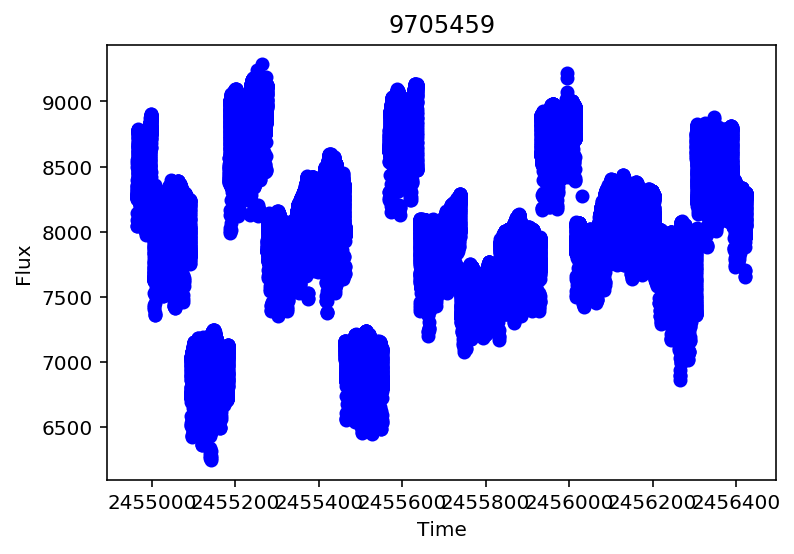

In [2]:
import h5py
hdf5_file = h5py.File("data/light_curves.hdf5", 'r')

kic_number = 9705459
whole_lc = LightCurve.from_hdf5(hdf5_file, kic_number)

whole_lc.plot()

In [3]:
from salter import kic_to_params

# Get transit parameters from exoplanets table
params = kic_to_params(kic_number)

In [4]:
for attr in dir(params):
    if not attr.startswith('_'):
        print("{0}: {1}".format(attr, getattr(params, attr)))

a: 8.43163572553153
b: 0.079
duration: 0.1132875
ecc: 0
fp: None
inc: 89.46316077240935
limb_dark: quadratic
per: 2.48658617
rp: 0.2052364490045567
t0: 2454967.110364
t_secondary: None
u: (0.49869999999999998, 0.1772)
w: 90


In [6]:
from scipy.ndimage import gaussian_filter
import numpy as np

extra_oot_time = 2 # [durations]; Extra transit durations to keep before ingress/after egress
polynomial_order = 1

near_transit = LightCurve(**whole_lc.mask_out_of_transit(oot_duration_fraction=extra_oot_time))
transits = near_transit.get_transit_light_curves()

# Compute maxes for each quarter
available_quarters = whole_lc.get_available_quarters()
quarters = [whole_lc.get_quarter(q) for q in whole_lc.get_available_quarters()]

quarterly_maxes = {}
set_upper_limit = 4e10
for i, quarter_number, lc in zip(range(len(available_quarters)),
                                 available_quarters, quarters):
    fluxes = lc.fluxes[lc.fluxes < set_upper_limit]
    smoothed_fluxes = gaussian_filter(fluxes, sigma=20)
    quarterly_maxes[quarter_number] = np.max(smoothed_fluxes)

for transit in transits:
    transit.subtract_add_divide_without_outliers(quarterly_max=quarterly_maxes[lc.quarters[0]],
                                                 plots=False)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:880: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:881: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/salter/salter/lightcurve.py:393: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/salter/salter/lightcurve.py:394: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/salter/salter/lightcurve.py:395: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the f

In [8]:
set(whole_lc.quarters)

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0}

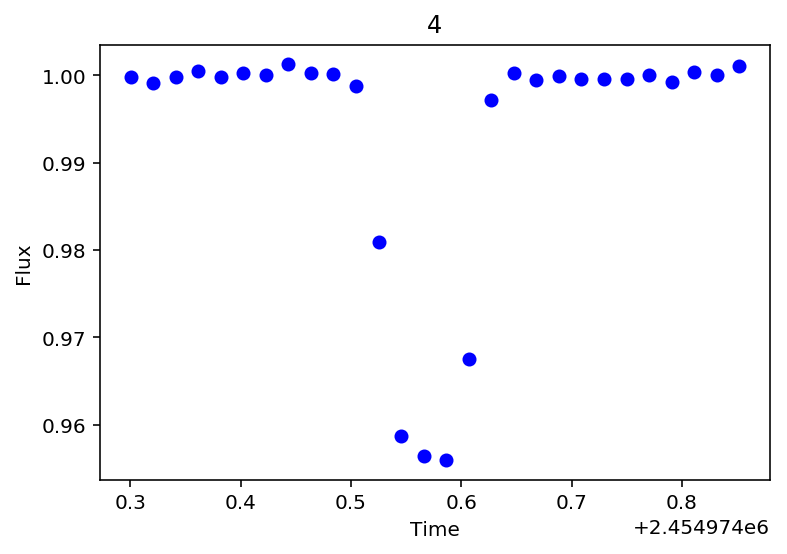

In [9]:
sample_transit = transits[4]

sample_transit.plot()

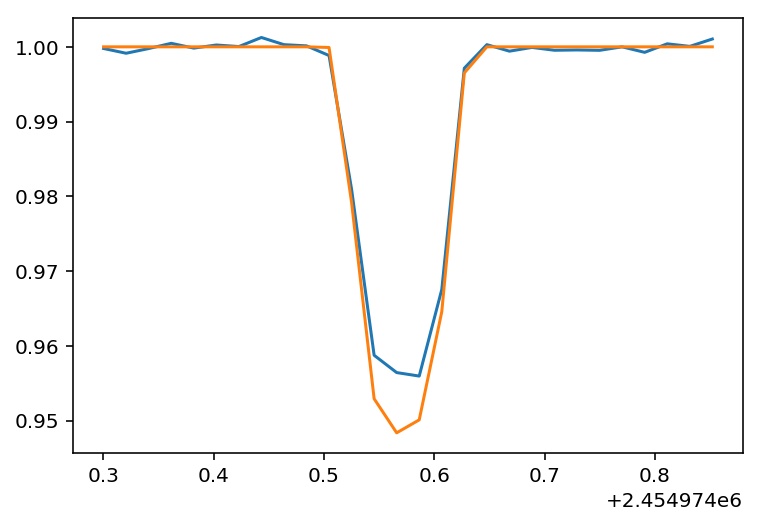

In [10]:
# Compute mandel & agol model
model = sample_transit.transit_model()

plt.plot(sample_transit.times.jd, sample_transit.fluxes)
plt.plot(sample_transit.times.jd, model)

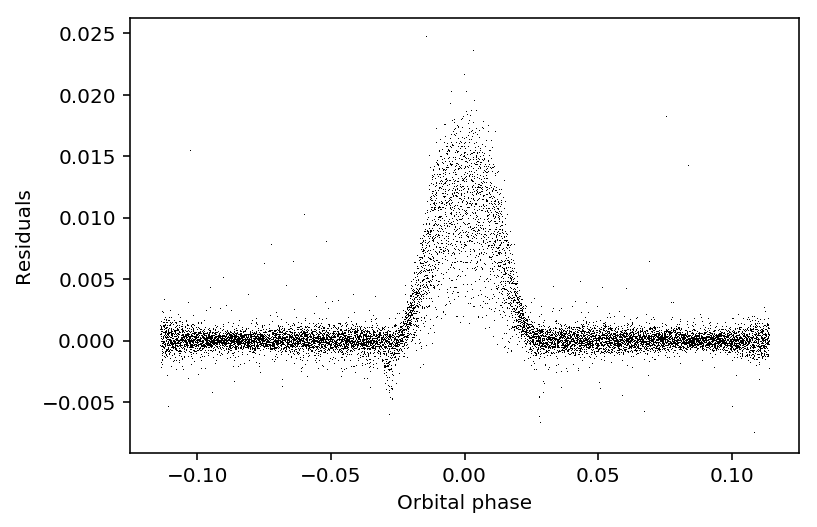

In [11]:
# plot residuals: 

for transit in transits:
    plt.plot(transit.phases(), transit.fluxes - transit.transit_model(), 'k,')
plt.xlabel('Orbital phase')
plt.ylabel('Residuals')